Source: https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
stock_data = yf.download('AAPL', start='2018-01-01', end='2022-09-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.018421,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.011288,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.201767,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.670879,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.516094,82271200


Text(0, 0.5, 'Prices ($)')

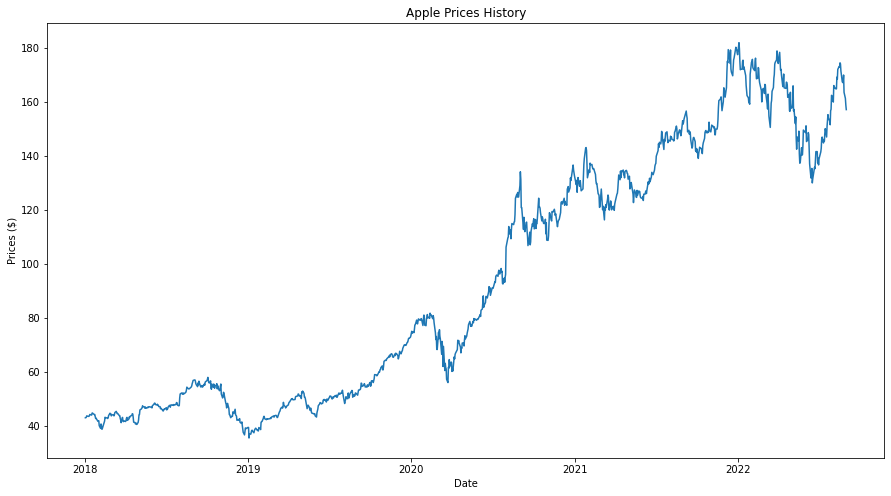

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Apple Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [4]:
#Picking close price 
close_prices = stock_data['Close']
values = close_prices.values

#Calculate the data size for 80% of the dataset. The math.ceil method is to ensure the data size is rounded up to an integer.
training_data_len = math.ceil(len(values)* 0.8)

#Using scaler so that the price will be in the range of 0 to 1 to fasten model processing time
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# Convert the feature data (x_train) and label data (y_train) into Numpy array as it is the data format accepted by the Tensorflow when training a neural network model. Reshape again the x_train and y_train into a three-dimensional array as part of the requirement to train a LSTM model.
# To use LSTM, data needs to be in 3D array format: [batch_size, sequence_length, n_features]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
#Struture test data
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Use an open-source machine learning library, Tensorflow, to set up our LSTM network architecture.

In [13]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

2022-09-09 14:49:49.130382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Adopt “adam” optimizer and set the mean square error as loss function
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=9)

Epoch 1/9
880/880 [==============================] - 15s 15ms/step - loss: 0.0021
Epoch 2/9
880/880 [==============================] - 13s 14ms/step - loss: 8.5108e-04
Epoch 3/9
880/880 [==============================] - 13s 15ms/step - loss: 6.2139e-04
Epoch 4/9
880/880 [==============================] - 13s 15ms/step - loss: 6.8584e-04
Epoch 5/9
880/880 [==============================] - 13s 15ms/step - loss: 6.0816e-04
Epoch 6/9
880/880 [==============================] - 13s 15ms/step - loss: 6.1444e-04
Epoch 7/9
880/880 [==============================] - 13s 15ms/step - loss: 3.6263e-04
Epoch 8/9
880/880 [==============================] - 13s 15ms/step - loss: 4.1055e-04
Epoch 9/9
880/880 [==============================] - 13s 15ms/step - loss: 3.8055e-04


In [15]:
#Test the model accurancy
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 1s 18ms/step


1.5486502789436503

/var/folders/gj/4l0y085529x1vdmxg_yh405c0000gp/T/ipykernel_16421/747112531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


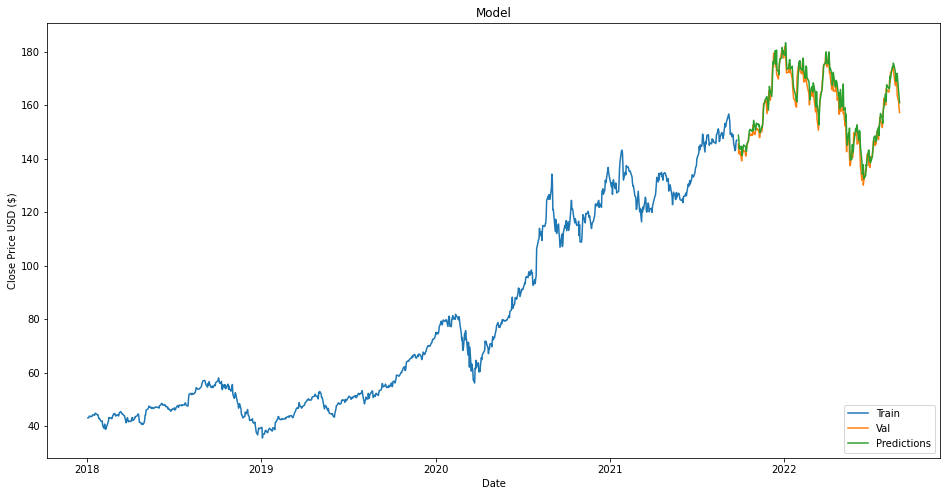

In [16]:
#Visual the prediction 
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
validation

,Close,Predictions
Date,,
2021-09-27,145.369995,148.745895
2021-09-28,141.910004,147.130539
2021-09-29,142.830002,143.726410
2021-09-30,141.500000,144.704483
2021-10-01,142.649994,143.453796
...,...,...
2022-08-25,170.029999,169.319946
2022-08-26,163.619995,171.851624
2022-08-29,161.380005,165.126678


In [20]:
test_data

array([[0.69452937],
       [0.71289586],
       [0.72696088],
       [0.7443715 ],
       [0.73529067],
       [0.74805841],
       [0.74389351],
       [0.75167707],
       [0.77564222],
       [0.77106768],
       [0.75679784],
       [0.72989674],
       [0.75515916],
       [0.75003839],
       [0.75959721],
       [0.77161391],
       [0.77454987],
       [0.75939239],
       [0.74717078],
       [0.75167707],
       [0.75317917],
       [0.75085778],
       [0.7634207 ],
       [0.76062133],
       [0.76137238],
       [0.75509092],
       [0.75474951],
       [0.75140401],
       [0.75317917],
       [0.77386705],
       [0.77530091],
       [0.78909277],
       [0.78274307],
       [0.75659302],
       [0.7589144 ],
       [0.76908769],
       [0.77946581],
       [0.77885124],
       [0.77024839],
       [0.76464964],
       [0.77188707],
       [0.80274814],
       [0.79394047],
       [0.79858325],
       [0.80636681],
       [0.81080486],
       [0.82712303],
       [0.816

In [21]:
values

array([ 43.06499863,  43.05749893,  43.25749969, ..., 161.38000488,
       158.91000366, 157.22000122])

In [25]:
scaler.inverse_transform(x_test)

ValueError: Found array with dim 3. None expected <= 2.